<a href="https://colab.research.google.com/github/boscoybarra/customer-transaction-prediction/blob/master/Augmented_EDA_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

In [0]:
import pandas as pd
import numpy as np
import gc

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

# Scikit-learn
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Skopt functions
!pip install scikit-optimize
from skopt import gp_minimize
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Metrics
from sklearn.metrics import average_precision_score, roc_auc_score, mean_absolute_error

import os
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

    100% |████████████████████████████████| 81kB 3.8MB/s 


In [0]:
santander_data = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/train.csv')
santander_data_test = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/test.csv')

In [0]:
# train_df = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/train.csv')
# test_df = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/test.csv')
# sample_submission = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/sample_submission.csv')

In [0]:
# Taking the labels (price)
label_df = santander_data['target']

In [0]:
santander_data.drop(['ID_code','target'], axis=1, inplace=True)

santander_data_test.drop('ID_code', axis=1, inplace=True)
santander_data.head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,-4.3781,7.9232,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,7.1971,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,-3.1882,9.0827,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,0.1287,7.9682,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


In [0]:
santander_data_test.head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
5,5.9862,-2.2913,8.6058,7.0685,14.2465,-8.6761,4.2467,14.7632,1.8790,7.2842,...,-2.1115,7.1178,-0.4249,8.8781,14.9438,-2.2151,-6.0233,9.8117,17.1127,10.8240
6,8.4624,-6.1065,7.3603,8.2627,12.0104,-7.2073,4.1670,13.0809,-4.3004,6.3181,...,12.3609,6.8661,4.0971,8.8484,17.5010,0.0295,7.7443,9.1509,18.4736,5.1499
7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,...,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
8,6.9856,0.8402,13.7161,4.7749,8.6784,-13.7607,4.3386,14.5843,2.5883,7.2215,...,-3.4657,7.8754,2.4698,-0.0362,16.7144,0.1221,-1.4328,9.9207,16.9865,-3.3304
9,10.3811,-6.9348,14.6690,9.0941,11.9058,-10.8018,3.4508,20.2816,-1.4112,6.7401,...,1.8052,11.0723,0.8907,4.7680,15.1425,0.6075,-4.4447,9.5788,15.8146,9.3457


In [0]:
santander_data.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [0]:
santander_data[santander_data.isnull().any(axis=1)]

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199


In [0]:
santander_data.select_dtypes(exclude=np.number).columns

Index([], dtype='object')

In [0]:
len_train = len(santander_data)
len_train

200000

In [0]:
#Merge test and train
merged = pd.concat([santander_data, santander_data_test])
#Saving the list of original features in a new list `original_features`.
original_features = merged.columns
merged.shape

(400000, 200)

In [0]:
idx = features = merged.columns.values[0:200]
for df in [merged]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [0]:
print("Total number of features: ",merged.shape[1])

Total number of features:  208


In [0]:
train_df = merged.iloc[:len_train]
train_df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,17.9697,-8.9996,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [0]:
X_test = merged.iloc[len_train:]
X_test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,15.4722,-8.7197,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,19.1293,-20.9760,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,19.8956,-23.1794,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,13.0168,-4.2108,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,13.9260,-9.1846,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


Data Augment Augmentation is a method to increase the amount of training data by randomly shuffle/transform the features in a certain way. It improves accuracy by letting the model see more cases of both "1" and "0" samples in training so the model can generalize better to new data.

Thanks to Jiwei Lu for teaching this new concept . https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment

In [0]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [0]:
"""train_df = santander_data
X_test = santander_data_test"""
del santander_data
del santander_data_test
gc.collect()

37

In [0]:
skf_three= StratifiedKFold(n_splits=12, shuffle=False, random_state=2319)

In [0]:
param = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "verbosity" : 1,
}

In [0]:
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(len(X_test))
feats = [f for f in train_df.columns]
    
for n_fold, (train_idx, valid_idx) in enumerate(skf_three.split(train_df[feats], label_df)):
    X_train, y_train = train_df.iloc[train_idx][feats], label_df.iloc[train_idx]
    X_valid, y_valid = train_df.iloc[valid_idx][feats], label_df.iloc[valid_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(n_fold + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
        
    clf = lgb.train(param, trn_data,1000000, valid_sets = [trn_data, val_data], verbose_eval=2000, early_stopping_rounds = 4000)
        

    oof_preds[valid_idx] = clf.predict(train_df.iloc[valid_idx][feats], num_iteration=clf.best_iteration)
    sub_preds += clf.predict(X_test[feats], num_iteration=clf.best_iteration) / 12


print('Full AUC score %.6f' % roc_auc_score(label_df, oof_preds))


pred3=sub_preds

Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[2000]	training's auc: 0.900718	valid_1's auc: 0.886382
[4000]	training's auc: 0.911551	valid_1's auc: 0.894677
[6000]	training's auc: 0.918087	valid_1's auc: 0.898908
[8000]	training's auc: 0.92275	valid_1's auc: 0.900457
[10000]	training's auc: 0.926807	valid_1's auc: 0.901593
[12000]	training's auc: 0.930668	valid_1's auc: 0.901954
[14000]	training's auc: 0.934356	valid_1's auc: 0.902061
[16000]	training's auc: 0.937883	valid_1's auc: 0.90199
[18000]	training's auc: 0.941275	valid_1's auc: 0.9018
Early stopping, best iteration is:
[14115]	training's auc: 0.934556	valid_1's auc: 0.90211
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[2000]	training's auc: 0.901143	valid_1's auc: 0.888357
[4000]	training's auc: 0.911882	valid_1's auc: 0.894944
[6000]	training's auc: 0.918424	valid_1's auc: 0.897669
[8000]	training's auc: 0.923107	valid_1's auc: 0.898639
[10000]	training's auc: 0.9271

In [0]:
sample_submission = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/sample_submission.csv')
sample_submission['target'] = pred3
sample_submission.to_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/submission_last_run2.csv', index=False)

NameError: ignored

In [0]:
# mean_auc = np.mean(pred3)
# std_auc = np.std(pred3)
# all_auc = roc_auc_score(label_df, oof_preds)
# print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

In [0]:
sample_submission = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/sample_submission.csv')
sample_submission['target'] = pred3
sample_submission.to_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/submission_last_run2.csv', index=False)

NameError: ignored

In [0]:
# sample_submission = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/sample_submission.csv')
# sample_submission['target'] = pred3
# sample_submission.to_csv('submission_best.csv', index=False)

In [0]:
random_state = 42
np.random.seed(random_state)
df_train = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/test.csv')

In [0]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [0]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [0]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

In [27]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.892841	valid_1's auc: 0.882419
[2000]	training's auc: 0.90163	valid_1's auc: 0.88934
[3000]	training's auc: 0.907981	valid_1's auc: 0.893628
[4000]	training's auc: 0.912751	valid_1's auc: 0.896402
[5000]	training's auc: 0.916476	valid_1's auc: 0.898194
[6000]	training's auc: 0.919533	valid_1's auc: 0.899245
[7000]	training's auc: 0.922145	valid_1's auc: 0.899821
[8000]	training's auc: 0.924572	valid_1's auc: 0.90013
[9000]	training's auc: 0.926832	valid_1's auc: 0.900341
[10000]	training's auc: 0.929014	valid_1's auc: 0.900328
[11000]	training's auc: 0.931123	valid_1's auc: 0.900265
[12000]	training's auc: 0.933199	valid_1's auc: 0.900248
Early stopping, best iteration is:
[9165]	training's auc: 0.927196	valid_1's auc: 0.900388
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.892959	valid_1's auc: 0.882272
[2000]	training's auc: 0.901561	valid_1's auc: 0.8891

In [32]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.901648205, std: 0.003121000. All auc: 0.901617757.


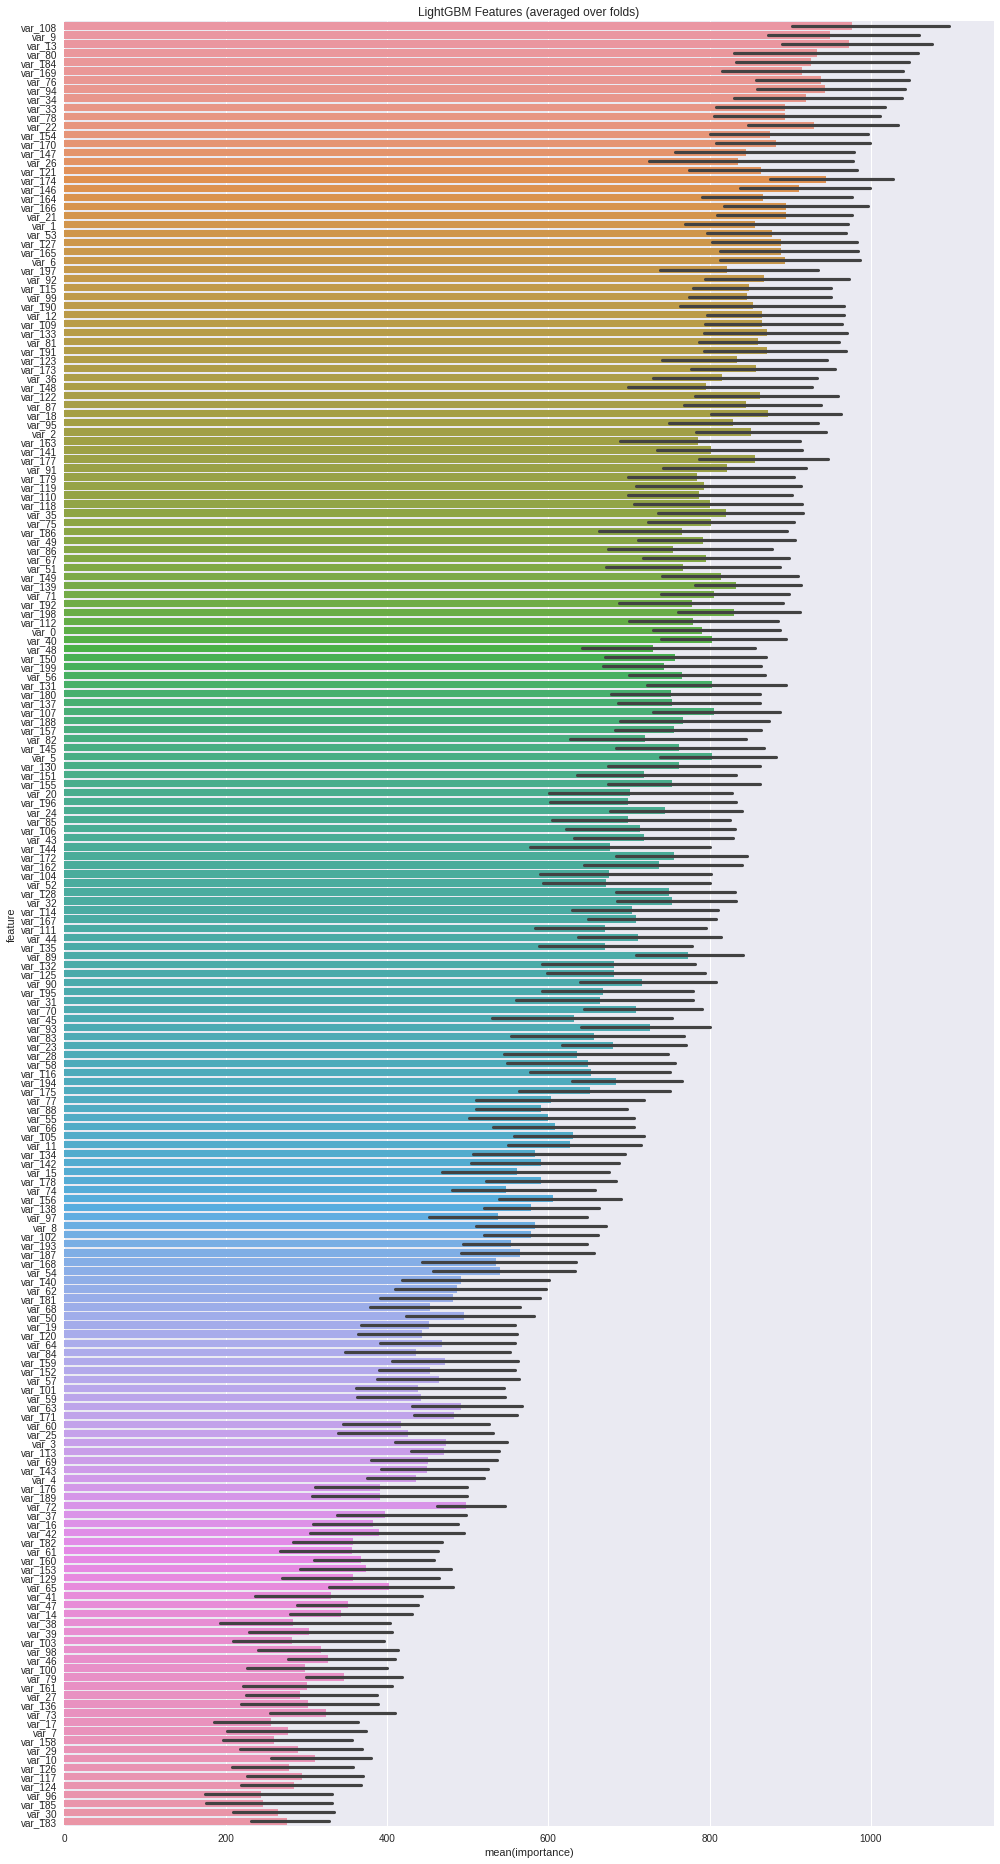

In [29]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [0]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/lgb_submission.csv", index=False)
oof.to_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/lgb_oof.csv', index=False)

In [0]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/lgb_submission2.csv", index=False)
oof.to_csv('/content/drive/My Drive/kaggle/santander-customer-transaction-prediction/lgb_oof2.csv', index=False)